In [1]:
# Usual imports
import numpy as np
import matplotlib.pyplot as plt

# Empathic library imports
import empathicTD as empTD
import offTD as offTD

from models import Model # Class to store model characteristic
from policies import Policy, LeftRightPolicy # Class to store and generate markov chain matrix
from utils import comparatorTD # Tool to evaluate the TD algorithms on a model

In [2]:
%matplotlib notebook

# Two states model

### Definition

In [3]:
# Define the target and behaviro policies
pi = LeftRightPolicy(n = 2, p_right = 1) # Always to the right
mu = LeftRightPolicy(n = 2) # Uniform is default

# Define the model
model = Model(
            ## Model definition
                features = [1, 2], # features function
                R = np.zeros((2,2)), # transition reward
                pi = pi, # target policy
                mu = mu, # behavior policy
    
            ## Parameters for TD
                alpha = 0.001,
                lambdas = [0, 0], # lambda function
                I = [1, 0], # interest function
                discounts = [0.9, 0.9], # discount function
    
            ## Initialisation
                S0 = 0,
                theta0 = 1,
             )  

# the comparator to test the TDs on the model
comparator = comparatorTD(model)

### Running particles

In [4]:
T, N = 5000, 200
comparator.run(T, N)

empathic TD has been computed for 5000 steps and 200 particles.
offTD has been computed for 5000 steps and 200 particles.


### Theta estimates

<IPython.core.display.Javascript object>


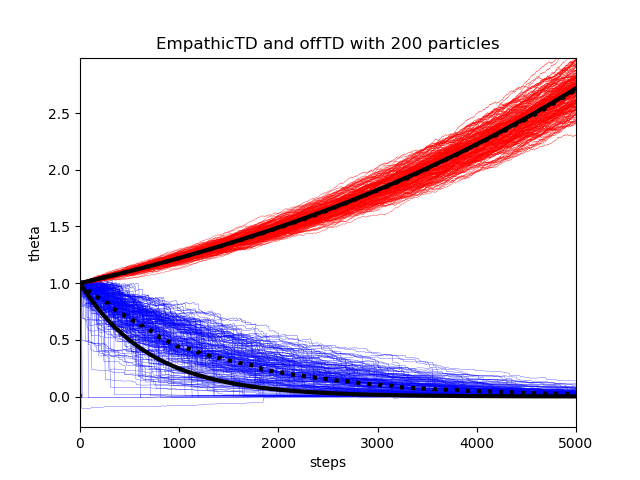

In [5]:
comparator.plot_theta()

## With other rewards

### Definition

In [16]:
# Define the target and behaviro policies
pi = LeftRightPolicy(n = 2, p_right = 1) # Always to the right
mu = LeftRightPolicy(n = 2) # Uniform is default

# Define the model
model = Model(
            ## Model definition
                features = np.identity(2), # features function
                R = [[0,3], [0, 10]], # transition reward
                pi = pi, # target policy
                mu = mu, # behavior policy
                v_pi = [93, 100], # exact state value under pi
    
            ## Parameters for TD
                alpha = 0.001,
                lambdas = [0, 0], # lambda function
                I = [1, 0], # interest function
                discounts = [0.9, 0.9], # discount function
    
            ## Initialisation
                S0 = 0,
                theta0 = 1,
             )  

# the comparator to test the TDs on the model
comparator = comparatorTD(model)

### Running particles

In [17]:
T, N = 25000, 200
comparator.run(T, N)

empathic TD has been computed for 25000 steps and 200 particles.
offTD has been computed for 25000 steps and 200 particles.


### Theta estimates

<IPython.core.display.Javascript object>


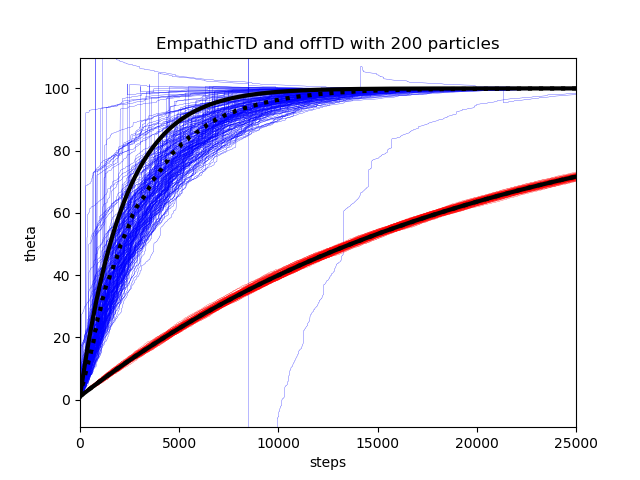

In [18]:
comparator.plot_theta(1)

### MSVE

<IPython.core.display.Javascript object>


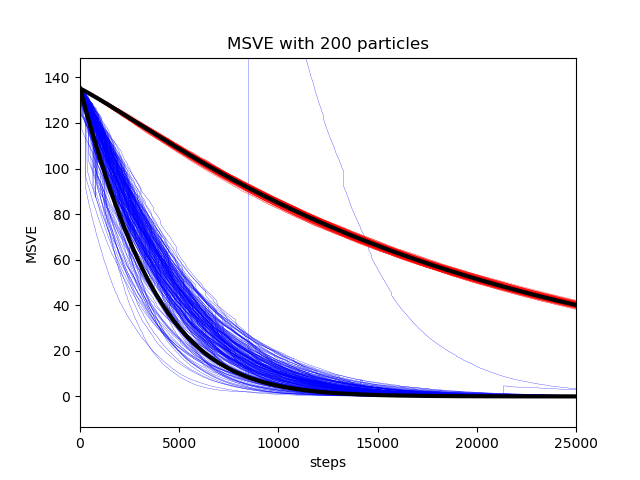

In [19]:
comparator.plot_msve()

## Bad behavior policy

In [25]:
# Define the target and behaviro policies
pi = LeftRightPolicy(n = 2, p_right = 1) # Always to the right
mu = LeftRightPolicy(n = 2) # Uniform is default

# Define the model
model = Model(
            ## Model definition
                features = np.identity(2), # features function
                R = [[0,3], [0, 10]], # transition reward
                pi = pi, # target policy
                mu = mu, # behavior policy
                v_pi = [93, 100], # exact state value under pi
    
            ## Parameters for TD
                alpha = 0.001,
                lambdas = [0, 0], # lambda function
                I = [1, 0], # interest function
                discounts = [0.9, 0.9], # discount function
    
            ## Initialisation
                S0 = 0,
                theta0 = 1,
             )  

# the comparator to test the TDs on the model
comparator = comparatorTD(model)

### Running particles

In [26]:
comparator.run(25000, 50)

empathic TD has been computed for 25000 steps and 50 particles.
offTD has been computed for 25000 steps and 50 particles.


### Theta estimates

<IPython.core.display.Javascript object>


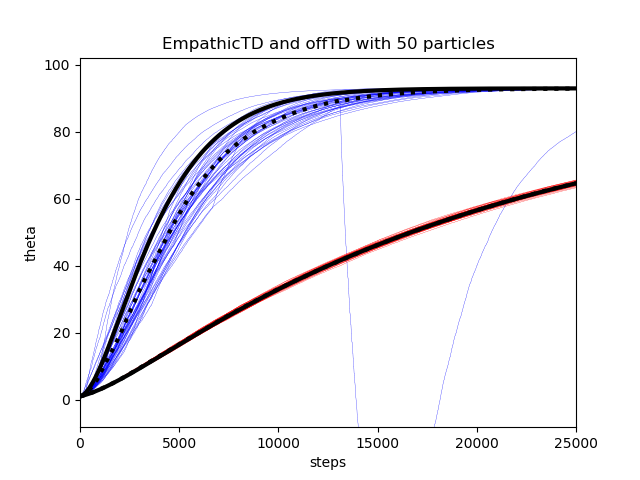

In [28]:
comparator.plot_theta(0)

###  MSVE

<IPython.core.display.Javascript object>


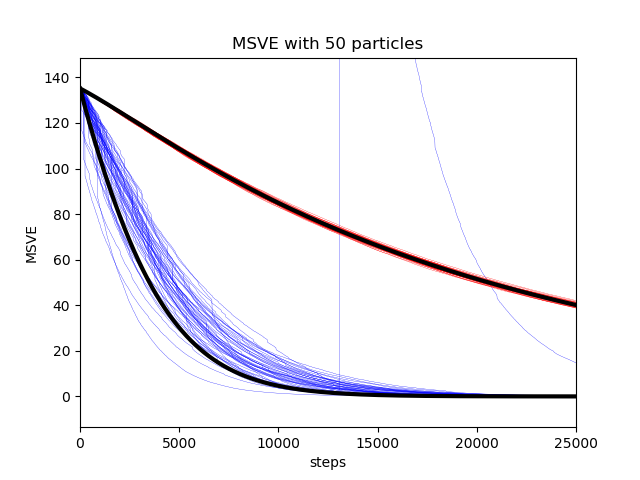

In [29]:
comparator.plot_msve()

# Five states model

In [41]:
# Define the target and behaviro policies
pi = LeftRightPolicy(n = 5, p_right = 1) # Always to the right
mu = LeftRightPolicy(n = 5, p_left = 2/3) # Uniform is default

# Define the model
model = Model(
            ## Model definition
                # features function
                features = [[1, 0, 0],
                            [1, 1, 0],
                            [0, 1, 0],
                            [0, 1, 1],
                            [0, 0, 1]], 
                R = np.ones((5,5)), # transition reward
                pi = pi, # target policy
                mu = mu, # behavior policy
                v_pi = [4, 3, 2, 1, 1], # state value under pi
    
            ## Parameters for TD
                alpha = 0.001,
                lambdas = np.zeros(5), # lambda function
                I = np.ones(5), # interest function
                discounts = [0, 1, 1, 1, 0], # discount function
    
            ## Initialisation
                S0 = 0,
                theta0 = 0,
             )  

# the comparator to test the TDs on the model
comparator = comparatorTD(model)

### Running particles

In [44]:
comparator.run(50000, 200)

empathic TD has been computed for 50000 steps and 200 particles.
offTD has been computed for 50000 steps and 200 particles.


### MSVE

<IPython.core.display.Javascript object>


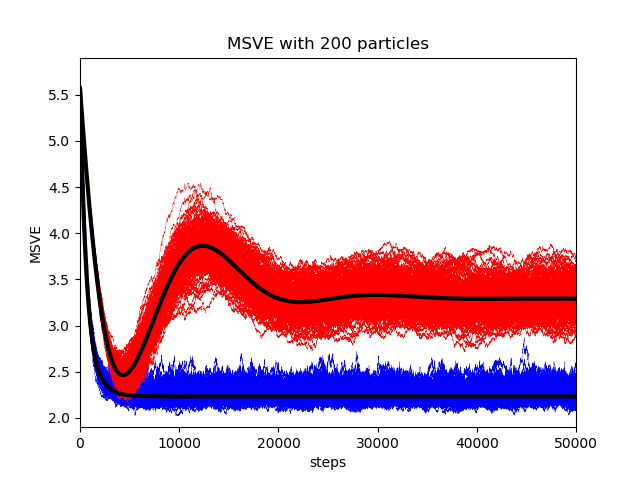

In [45]:
comparator.plot_msve()

### Theta estimates

<IPython.core.display.Javascript object>


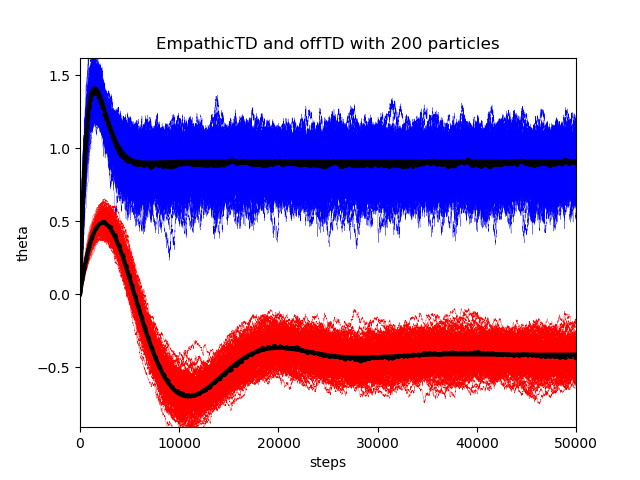

In [46]:
comparator.plot_theta(1)